# EDA and Model Training

In [1]:
%load_ext autoreload
%autoreload 2

## Change to project directory (Google Colab)

In [2]:
import os
os.chdir('/content/drive/MyDrive/projects/income-prediction-ml-deployment/notebooks')
os.listdir()

['EDA-and-Model-Training.ipynb',
 '.ipynb_checkpoints',
 'Generate-Dataset-Description.ipynb']

## Install package (Google Colab)

In [3]:
!pip install -e ../.

Obtaining file:///content/drive/My%20Drive/projects/income-prediction-ml-deployment
ERROR: Operation cancelled by user


In [183]:
!pip install scikit-learn==0.24.*

     |████████████████████████████████| 22.3MB 66.0MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


## Load the data

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
from project.utils import load_data
from src.utils import remove_extra_whitespace


In [6]:
df_train = load_data('train')
df_test = load_data('test')

In [7]:
object_cols = df_train.select_dtypes('object').columns
df_train[object_cols] = df_train[object_cols].applymap(remove_extra_whitespace)
df_test[object_cols] = df_test[object_cols].applymap(remove_extra_whitespace)

In [8]:
df_train.replace('?', np.nan, inplace=True)
df_test.replace('?', np.nan, inplace=True)


## Explore the data

In [9]:
df = df_train # for ease of writing

dtypes

In [10]:
df.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
income            object
dtype: object

Number of unique categories in each

* Since each of them are either categorical or ordinal

In [11]:
clmn_cat_stats = df.apply(lambda col: pd.Series({'num_unique': col.nunique(), 'column_type': col.dtype})).T
clmn_cat_stats

,num_unique,column_type
age,73,int64
workclass,8,object
fnlwgt,21648,int64
education,16,object
education-num,16,int64
marital-status,7,object
occupation,14,object
relationship,6,object
race,5,object
sex,2,object


In [12]:
from src.visualize import ColumnTypePlotter

column_types = {'continuous': ['fnlwgt', 'capital-gain', 'capital-loss', 
                               'hours-per-week'],
                'ordinal': ['education-num'],
                'nominal': ['workclass', 'education', 'marital-status', 
                                'occupation', 'relationship', 'race', 'sex', 'native-country']}

ctype_plotter = ColumnTypePlotter(column_types)


### `Continuous`

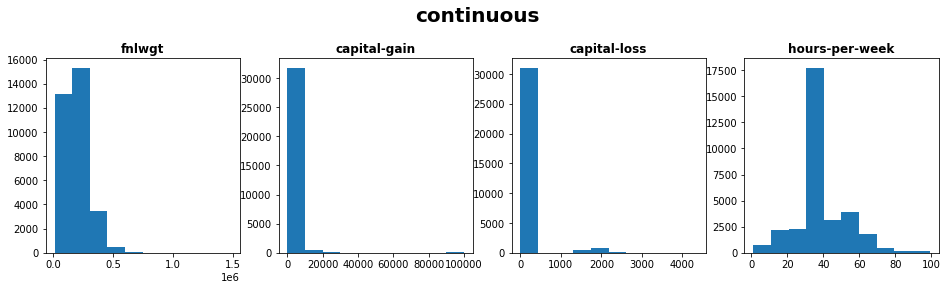

In [13]:
ctype_plotter.plot(df, 'continuous', figsize=(16, 4));

### `Ordinal`

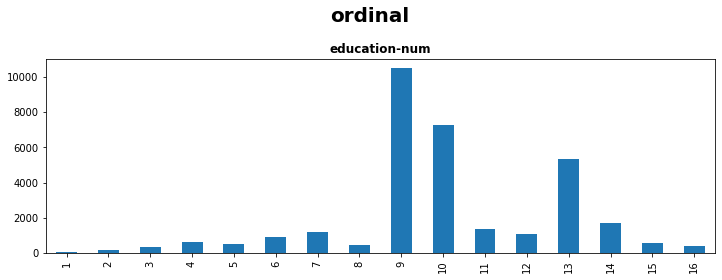

In [14]:
ctype_plotter.plot(df, 'ordinal');

### `Nominal`

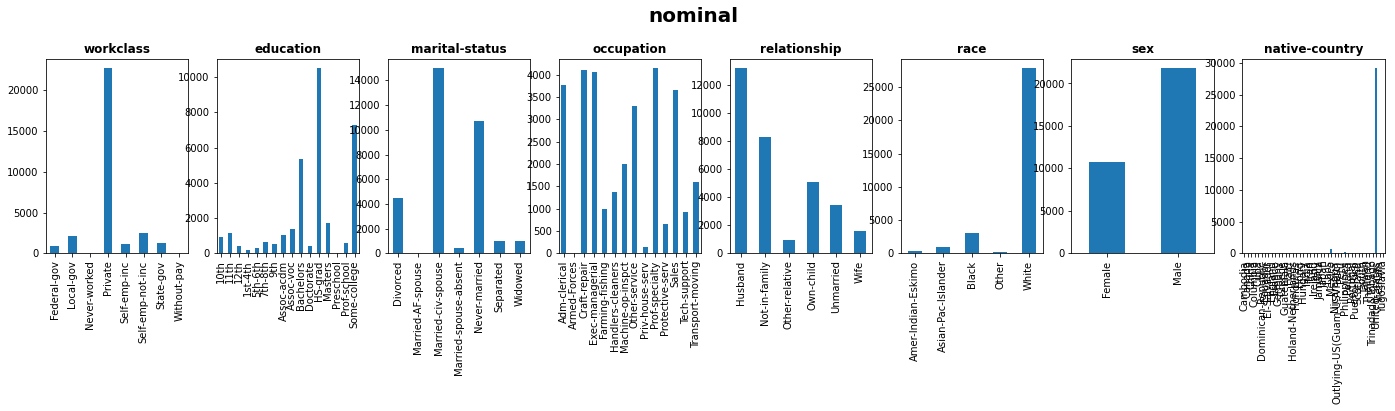

In [15]:
ctype_plotter.plot(df, 'nominal', figsize=(24, 4));

* workclass and occupation has a `?` category which indicates a missing value.

### Missing Values

In [16]:
df.isna().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income               0
dtype: int64

### Custom LabelEncoder to preserve NaN values

In [17]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
class CustomOrdinalEncoder(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        self.le_lst = [OrdinalEncoder() for _ in range(X.shape[0])]

        for col_idx in range(X.shape[-1]):
            x = X[:, col_idx]
            le = self.le_lst[col_idx]
            le.fit(x[~pd.isna(x)])

        return self

    def transform(self, X, y=None):

        X_tr = X.copy()
        for col_idx in range(X.shape[-1]):
            x = X[:, col_idx]
            le = self.le_lst[col_idx]
            
            is_na = pd.isna(x)
            X_tr[~is_na, col_idx] = self.le.transform(x[~is_na])
         
        return X_tr

In [18]:
X = df[['workclass']]
X[~pd.isna(X)]

,workclass
0,State-gov
1,Self-emp-not-inc
2,Private
3,Private
4,Private
...,...
32556,Private
32557,Private
32558,Private
32559,Private


## Distribution of Target label

* Imbalanced classification problem

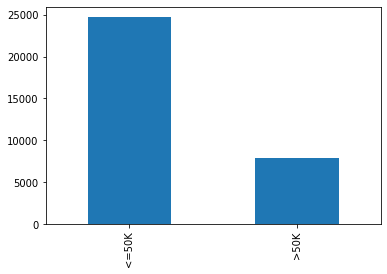

In [19]:
df['income'].value_counts().plot(kind='bar');

In [20]:
df_train['income'].unique()

array(['<=50K', '>50K'], dtype=object)

In [21]:
df_test['income'].unique()

array(['<=50K.', '>50K.'], dtype=object)

In [22]:
df_test['income'] = df_test['income'].str.replace('\.$', '')
df_test['income'].unique()

array(['<=50K', '>50K'], dtype=object)

## Train and test splits

In [23]:
dfX_train, dfy_train = df_train.drop('income', axis=1), df_train['income']
dfX_test, dfy_test = df_test.drop('income', axis=1), df_test['income']


In [24]:
def get_train_test_ratio_stats(train_data, test_data):
    num_train = len(train_data)
    num_test = len(test_data)

    train_perc = round(num_train*100/(num_train + num_test))
    test_perc = 100 - train_perc

    ratio_stats = {'num_train': len(num_train), 'num_test': len(num_test), 
                   'train_perc': train_perc, 'test_perc': test_perc}
    
    return ratio_stats

In [25]:
num_train = len(dfy_train)
num_test = len(dfy_test)

train_perc = round(num_train*100/(num_train + num_test))
test_perc = 100 - train_perc

print(f'Train Size: {len(dfy_train)}, Test Size: {len(dfy_test)}, Ratio: {train_perc}:{test_perc}')

Train Size: 32561, Test Size: 16281, Ratio: 67:33


## Pipeline for preprocessing

In [44]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline



impute_enc_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ordinal_encode', OrdinalEncoder(handle_unknown='use_encoded_value', 
                                      unknown_value=-1))
])

impute_enc_cat = ColumnTransformer([
    ('impute_enc', impute_enc_pipe, column_types['nominal']),
],  remainder='passthrough')


pipe_preprocessing = Pipeline([
    ('impute_enc_cat', impute_enc_cat) 
])

> **Note**: As we are using RandomForest we don't require OneHotEncoding and also no feature scaling :)

In [45]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([
    ('preprocess', pipe_preprocessing),
    ('clf', RandomForestClassifier())
])

In [46]:
pipe.fit(dfX_train, dfy_train)

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('impute_enc_cat',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('impute_enc',
                                                                   Pipeline(steps=[('impute',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('ordinal_encode',
                                                                                    OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                   unknown_value=-1))]),
                                                                   ['workclass',
                                                                    'education',
                   

In [47]:
y_test_pred = pipe.predict(dfX_test)

## Evaluation

In [48]:
y_train_pred = pipe.predict(dfX_train)
y_test_pred = pipe.predict(dfX_test)


In [49]:
y_train_pred

array(['<=50K', '<=50K', '<=50K', ..., '<=50K', '<=50K', '>50K'],
      dtype=object)

In [50]:
dfy_train.to_numpy()

array(['<=50K', '<=50K', '<=50K', ..., '<=50K', '<=50K', '>50K'],
      dtype=object)

In [51]:
from sklearn.metrics import classification_report

print('Train:', '\n------\n')
print(classification_report(dfy_train, y_train_pred))

print('Test:', '\n------\n')
print(classification_report(dfy_test, y_test_pred))

Train: 
------

              precision    recall  f1-score   support

       <=50K       1.00      1.00      1.00     24720
        >50K       1.00      1.00      1.00      7841

    accuracy                           1.00     32561
   macro avg       1.00      1.00      1.00     32561
weighted avg       1.00      1.00      1.00     32561

Test: 
------

              precision    recall  f1-score   support

       <=50K       0.89      0.93      0.91     12435
        >50K       0.73      0.61      0.66      3846

    accuracy                           0.85     16281
   macro avg       0.81      0.77      0.78     16281
weighted avg       0.85      0.85      0.85     16281



Our model is definitely overfitting. We should tune such that we can reduce the complexity of the RandomForest Model

## Tuning RandomForest

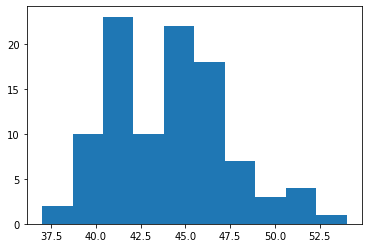

In [52]:
clf = pipe.named_steps['clf']
tree_depths = [est.get_depth() for est in clf.estimators_]
plt.hist(tree_depths);

* `n_estimators` - increasing it should not affect the Generalization error and hence does not lead to overfitting

In [53]:
RandomForestClassifier()

RandomForestClassifier()

In [54]:
rf_paramgrid = dict(n_estimators=[20, 50, 100, 200, 500], max_depth=range(30, 65, 5), 
                    max_features=['auto', 'sqrt'], min_samples_split=[5, 10, 20, 50], 
                    min_samples_leaf=[2, 5, 10, 25])

paramgrid = {'clf': [RandomForestClassifier()], **{f'clf__{param}': vals for param, vals in rf_paramgrid.items()}}
paramgrid

{'clf': [RandomForestClassifier()],
 'clf__max_depth': range(30, 65, 5),
 'clf__max_features': ['auto', 'sqrt'],
 'clf__min_samples_leaf': [2, 5, 10, 25],
 'clf__min_samples_split': [5, 10, 20, 50],
 'clf__n_estimators': [20, 50, 100, 200, 500]}

In [55]:
np.product([len(vals) for vals in rf_paramgrid.values()])

1120

In [67]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

rand_search = RandomizedSearchCV(pipe, paramgrid, n_iter=100, scoring='f1_weighted', cv=5, n_jobs=-1)

In [68]:
%%time

rand_search.fit(dfX_train, dfy_train.to_numpy())

CPU times: user 1min 5s, sys: 2.42 s, total: 1min 7s
Wall time: 29min 1s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocess',
                                              Pipeline(steps=[('impute_enc_cat',
                                                               ColumnTransformer(remainder='passthrough',
                                                                                 transformers=[('impute_enc',
                                                                                                Pipeline(steps=[('impute',
                                                                                                                 SimpleImputer(strategy='most_frequent')),
                                                                                                                ('ordinal_encode',
                                                                                                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                             

In [70]:
print('Best Score:', rand_search.best_score_)
print('Best Params:', rand_search.best_params_)

Best Score: 0.8592404262203477
Best Params: {'clf__n_estimators': 200, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 2, 'clf__max_features': 'sqrt', 'clf__max_depth': 30, 'clf': RandomForestClassifier(max_depth=30, max_features='sqrt', min_samples_leaf=2,
                       min_samples_split=20, n_estimators=200)}


In [71]:
best_pipe = rand_search.best_estimator_

y_train_pred = best_pipe.predict(dfX_train)
y_test_pred = best_pipe.predict(dfX_test)

print('Train:', '\n------\n')
print(classification_report(dfy_train, y_train_pred))

print('Test:', '\n------\n')
print(classification_report(dfy_test, y_test_pred))

Train: 
------

              precision    recall  f1-score   support

       <=50K       0.91      0.97      0.94     24720
        >50K       0.87      0.72      0.78      7841

    accuracy                           0.91     32561
   macro avg       0.89      0.84      0.86     32561
weighted avg       0.90      0.91      0.90     32561

Test: 
------

              precision    recall  f1-score   support

       <=50K       0.89      0.94      0.91     12435
        >50K       0.77      0.61      0.68      3846

    accuracy                           0.86     16281
   macro avg       0.83      0.78      0.80     16281
weighted avg       0.86      0.86      0.86     16281



Hurray! We have atleast managed to reduce overfitting! :)

## Save the best model

In [74]:
from project.config import PROJECT_DIR
import pickle

out_file = os.path.join(PROJECT_DIR, 'models', 'randomforest_best_pipe.pkl')
with open(out_file, 'wb') as f:
    pickle.dump(best_pipe, f)

## Save GridSearchCV results

In [95]:
list(dfX_train.columns)

['age',
 'workclass',
 'fnlwgt',
 'education',
 'education-num',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'capital-gain',
 'capital-loss',
 'hours-per-week',
 'native-country']

In [77]:
cv_results = pd.DataFrame(rand_search.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__n_estimators,param_clf__min_samples_split,param_clf__min_samples_leaf,param_clf__max_features,param_clf__max_depth,param_clf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.996788,0.044249,0.194925,0.024064,20,5,10,sqrt,45,"RandomForestClassifier(max_depth=30, max_featu...","{'clf__n_estimators': 20, 'clf__min_samples_sp...",0.851401,0.852869,0.855940,0.858361,0.858247,0.855364,0.002813,56
1,14.497736,0.089654,0.784615,0.003572,500,20,25,auto,45,"RandomForestClassifier(max_depth=30, max_featu...","{'clf__n_estimators': 500, 'clf__min_samples_s...",0.845353,0.848456,0.852336,0.857393,0.853805,0.851468,0.004190,89
2,14.488815,0.138324,0.800990,0.017355,500,50,25,sqrt,50,"RandomForestClassifier(max_depth=30, max_featu...","{'clf__n_estimators': 500, 'clf__min_samples_s...",0.846590,0.848547,0.852843,0.857062,0.853527,0.851714,0.003727,81
3,3.154260,0.058510,0.280098,0.001049,100,50,25,sqrt,45,"RandomForestClassifier(max_depth=30, max_featu...","{'clf__n_estimators': 100, 'clf__min_samples_s...",0.843221,0.848448,0.852565,0.858173,0.854133,0.851308,0.005104,92
4,1.918938,0.037667,0.226272,0.004114,50,5,10,auto,35,"RandomForestClassifier(max_depth=30, max_featu...","{'clf__n_estimators': 50, 'clf__min_samples_sp...",0.847156,0.852708,0.856341,0.859734,0.859147,0.855017,0.004652,60


In [92]:
import datetime
import pytz

now_timestr = datetime.datetime.now(pytz.timezone('Asia/Kolkata')).strftime('%Y%m%d_%H%M')

In [93]:
out_file = os.path.join(PROJECT_DIR, 'outputs', f'randsearch_results_{now_timestr}.csv')
cv_results.to_csv(out_file, index=False)